In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
import glob
import gc

from importlib import reload
import stilutils.utils.denoisers as ut
reload(ut)

NMFDenoiser = ut.NMFDenoiser
SVDDenoiser = ut.SVDDenoiser
PercentileDenoiser = ut.PercentileDenoiser
apply_mask = ut.apply_mask

plt.rcParams['figure.figsize'] = (15, 15)

In [2]:
def load_lst_as_np(input_lst: str, top=None):
    """Loads list of images as np array"""
    
    folder = input_lst.rsplit('/')[-2]
    if folder == 's1p5':
        datapath = 'entry_1/data_1/data'
    elif folder == 'c1_p':
        datapath = 'data/data'
    else:
        raise TypeError(f'must provide either c1_p or s1p5 input list, you provided {input_lst}')
    
    if top is None:
        top = int(1e10)

    from collections import defaultdict
    
    
    images = defaultdict(lambda: set())
    with open(input_lst) as fin_lst:
        for line in fin_lst:
            imagename, eventnum = line.replace('//','').split()
            images[imagename].add(int(eventnum))
    
    answ = []
    for image in images:
        idx = sorted(list(images[image]))
        full_image_path = f'{input_lst.rsplit("/", 1)[0]}/{image}'
        
        idx = idx[:top]

        with h5py.File(full_image_path, 'r') as f:
            answ.append(np.array(f[datapath][idx]))

    return np.vstack(answ)

def radial_profile(data, center=(720.057, 711.255)):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

def calc_zero_percentage(arr2d):
    return (arr2d<0).sum() / arr2d.shape[0] / arr2d.shape[1]

def calc_zero_num(arr2d):
    return (arr2d<0).sum()

# S1P5 data (with high background)

In [23]:
%%time

s1p5 = load_lst_as_np('/home/marinegor/xtal/s1p5/images/raw_data/c1_p/indexed.lst', top=50)
# s1p5 = load_lst_as_np('/home/marinegor/xtal/s1p5/images/raw_data/s1p5/indexed.lst', top=50)

s1p5.shape

CPU times: user 14 s, sys: 157 ms, total: 14.2 s
Wall time: 14.1 s


(50, 1440, 1440)

# Image plotting

In [24]:
s1p5 = apply_mask(s1p5, center=(720,710), radius=55)

# percentile = PercentileDenoiser(alpha=1e-2)
# nmf = NMFDenoiser()
# svd = SVDDenoiser()

In [25]:
%%time

s1p5_percentile_5 = PercentileDenoiser(alpha=5e-2).transform(s1p5, center=(720, 710), radius=55)
s1p5_percentile_1 = PercentileDenoiser(alpha=1e-2).transform(s1p5, center=(720, 710), radius=55)

CPU times: user 60 s, sys: 2.85 s, total: 1min 2s
Wall time: 1min 3s


In [26]:
# %%time

# s1p5_percentile_1_1 = PercentileDenoiser(alpha=1e-2).transform(s1p5_percentile_1, center=(720, 710), radius=55)

In [34]:
%%time

s1p5_nmf = NMFDenoiser().transform(np.abs(s1p5), center=(720, 710), radius=55)

/home/marinegor/.local/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


CPU times: user 6min 33s, sys: 2min 31s, total: 9min 4s
Wall time: 1min 45s


In [35]:
%%time

s1p5_nmf_alpha = NMFDenoiser().transform(np.abs(s1p5), center=(720, 710), radius=55, alpha=1e-2)

/home/marinegor/.local/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


CPU times: user 7min 22s, sys: 2min 36s, total: 9min 59s
Wall time: 2min 27s


In [36]:
%%time

s1p5_svd = SVDDenoiser().transform(s1p5, center=(720, 710), radius=55)

CPU times: user 45.5 s, sys: 37.5 s, total: 1min 23s
Wall time: 32.1 s


In [37]:
%%time

s1p5_svd_alpha = SVDDenoiser().transform(s1p5, center=(720, 710), radius=55, alpha=1e-2)

CPU times: user 57.2 s, sys: 21.7 s, total: 1min 18s
Wall time: 45.3 s


In [38]:
# from importlib import reload
# import stilutils.utils.denoisers as ut
# reload(ut)

# NMFDenoiser = ut.NMFDenoiser
# SVDDenoiser = ut.SVDDenoiser
# PercentileDenoiser = ut.PercentileDenoiser
# apply_mask = ut.apply_mask

# svd = SVDDenoiser()
# den = svd.transform(s1p5_m, center=(720, 710), radius=55, alpha=1e-2)
# bg = svd._bg
# scales = svd._scales

# for i in range(10):
#     plt.plot(radial_profile(den[i]), label=i)
# plt.legend()

[8, 36, 48, 4, 16, 7, 31, 48, 28, 30]


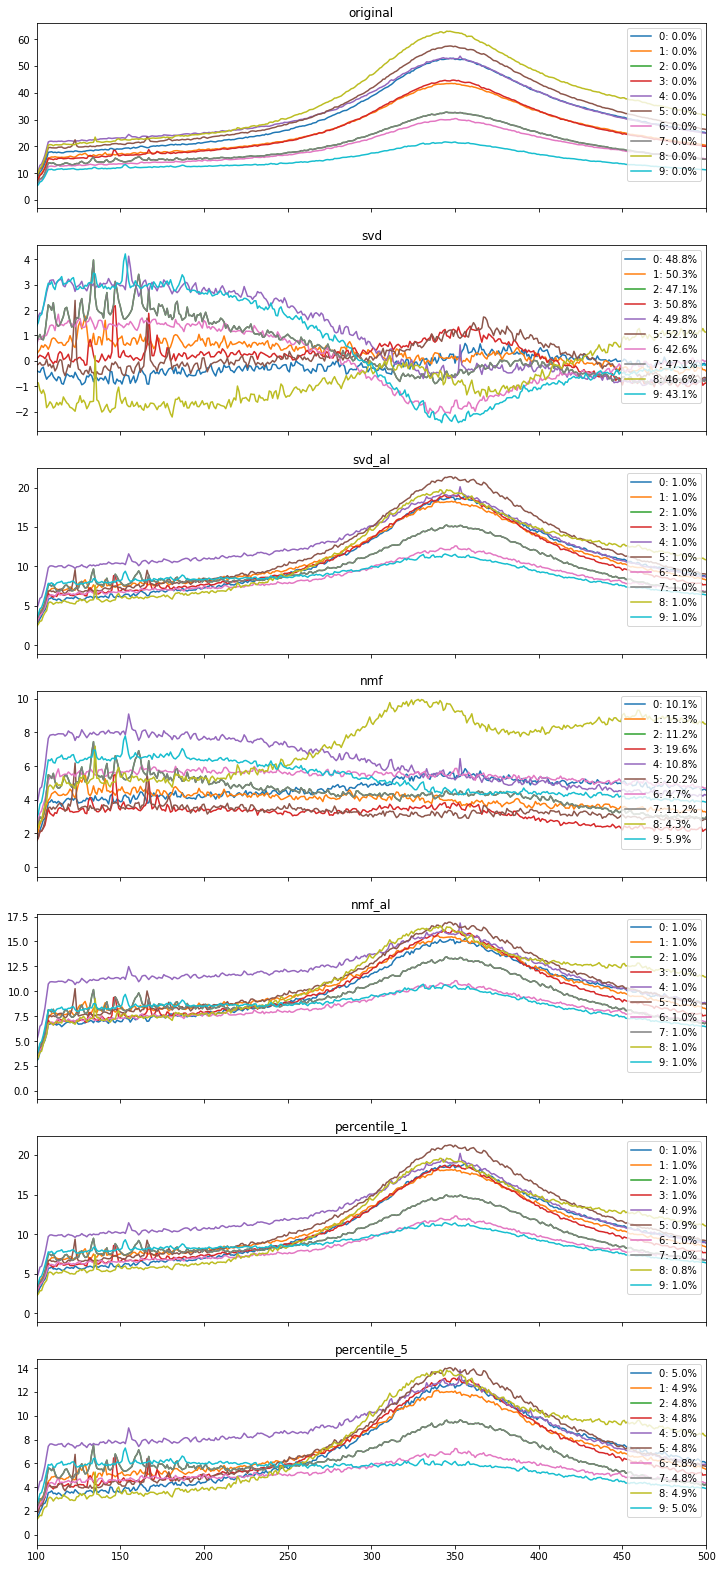

In [39]:
def plot_sample_profiles(images, seed=None, size=10, center=(720, 710), limit=None):
    import random
    random.seed(a=seed)
    
    arrs, labels = list(images.values()), list(images.keys())
    
    orig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (12, 4*len(arrs))
    
    n_arrs = len(arrs)
    
    if limit is None:
        limit = len(radial_profile(arrs[0]))
        
    arrs_idx = list(range(arrs[0].shape[0]))

    samples = [random.choice(arrs_idx) for _ in range(size)]
    print(samples)
    samples = [[arrs[i][idx] for i in range(n_arrs)] for idx in samples]
        
    fix, axs = plt.subplots(n_arrs, 1, sharex=True, sharey=False)
    
    for ax_id in range(n_arrs):
        for arr_id in range(size):
            arr = samples[arr_id][ax_id]
            axs[ax_id].plot(radial_profile(arr), 
                            label=f'{arr_id}: {calc_zero_percentage(arr)*100:.1f}%',
                           )
        if labels is not None:
            axs[ax_id].set_title(labels[ax_id])
        axs[ax_id].set_xlim((*limit))
        axs[ax_id].legend(loc=1)

    plt.rcParams['figure.figsize'] = orig_size


data = {
    'original':s1p5,
    'svd':s1p5_svd,
    'svd_al':s1p5_svd_alpha,
    'nmf':s1p5_nmf,
    'nmf_al':s1p5_nmf_alpha,
    'percentile_1':s1p5_percentile_1,
    'percentile_5':s1p5_percentile_5,
}

plot_sample_profiles(images=data, seed=1, limit=(100,500))

[8, 36, 48, 4, 16, 7, 31, 48, 28, 30]


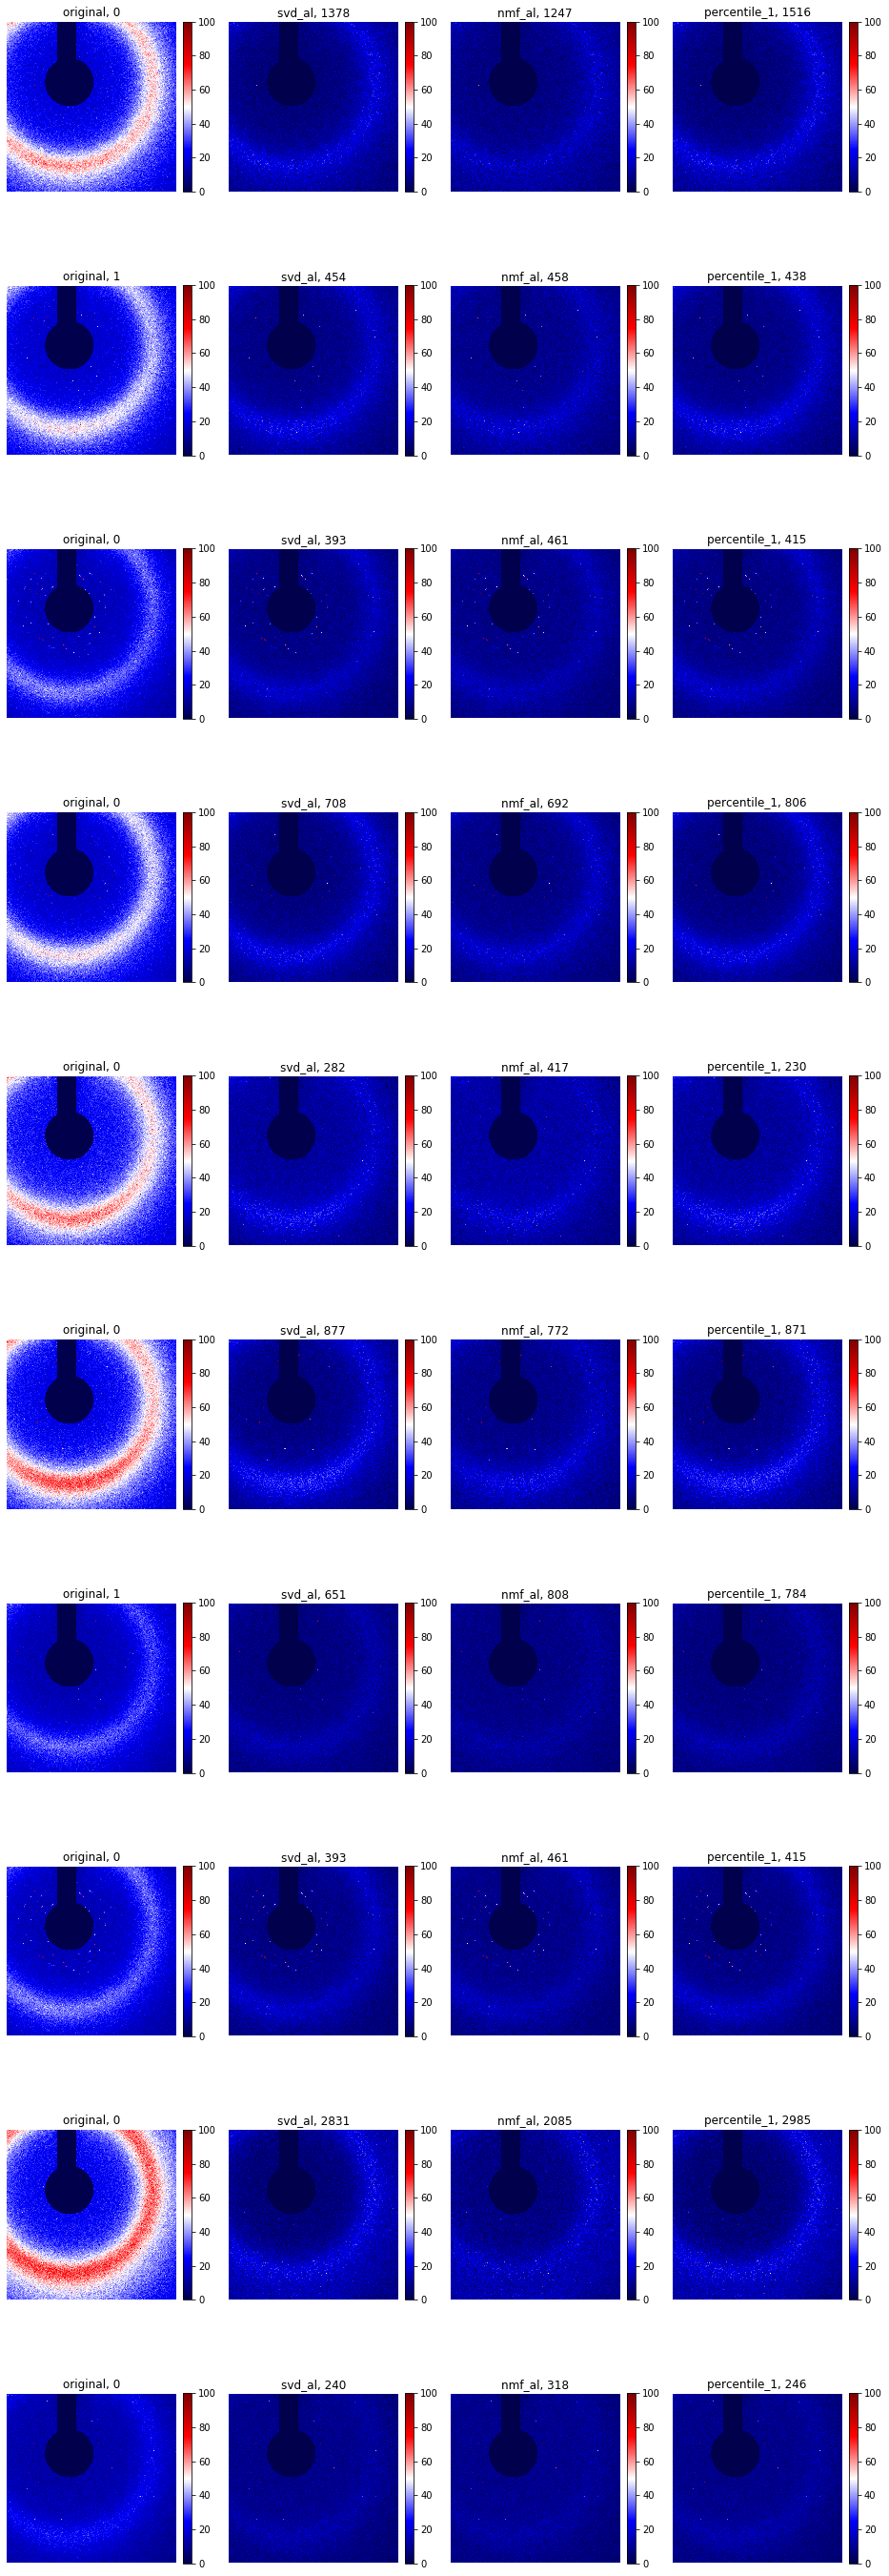

In [44]:
def plot_sample_images(images, 
                       size=5, 
                       seed=None,
                       center=(820, 810), 
                       side=(350, 350),
                      ):
    import random
    random.seed(a=seed)
    
    arrs, labels = list(images.values()), list(images.keys())
    x0 = center[0] - side[0]
    x1 = center[0] + side[0]
    y0 = center[1] - side[1]
    y1 = center[1] + side[1]
    n_arrs = len(arrs)

    orig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (4*n_arrs, 5*size)
    
        
    arrs_idx = list(range(arrs[0].shape[0]))
    samples = [random.choice(arrs_idx) for _ in range(size)]
    print(samples)
    samples = [[arrs[i][idx] for i in range(n_arrs)] for idx in samples]
        
    fig, axs = plt.subplots(size, n_arrs)
    
    for ax_id in range(n_arrs):
        for arr_id in range(size):
            arr = samples[arr_id][ax_id][x0:x1, y0:y1]
            ax = axs[arr_id][ax_id]
            
            im = ax.imshow(arr,
                           cmap='seismic',
                           vmin=0,
                           vmax=100
                           )
            p = calc_zero_num(arr)
            ax.set_title(f'{labels[ax_id]}, {p:d}')
            fig.colorbar(im, fraction=0.046, pad=0.04, ax=ax)
            ax.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = orig_size


data = {
    'original':s1p5,
#     'svd':s1p5_svd,
    'svd_al':s1p5_svd_alpha,
#     'nmf':s1p5_nmf,
    'nmf_al':s1p5_nmf_alpha,
    'percentile_1':s1p5_percentile_1,
#     'percentile_5':s1p5_percentile_5,
}


plot_sample_images(images=data, size=10, seed=1)